In [2]:
import sys
import numpy as np
import pandas as pd
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as NormColor
from tqdm import tqdm
import emcee
import corner
sys.path.append(".")
import HOD
from astropy.cosmology import Planck15
cosmo = Planck15 #FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
h = cosmo.H(0).value/100

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


Found best M_min 11.00 - M_sat 12.00 | chi 1.61


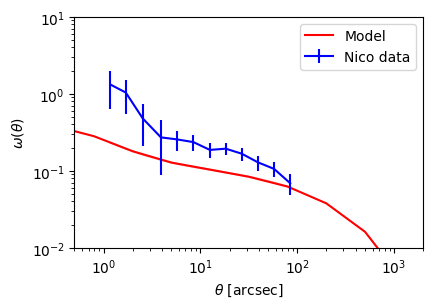

In [9]:
### Fit 2 halo ###
M_sat, M_min, sigma_logM, alpha = 10**11.5, 10**10.5, 0.2, 1.0
SHOW_HALO_TERMS = 1

def read_Nico_data(fname):
    data = pd.read_csv(fname, sep=' ')
    bin_centre = data['theta_bin'].to_numpy()
    w_obs = data['w_theta'].to_numpy()
    w_err = data['err_w_theta'].to_numpy()
    z_array = data['z_array'].to_numpy()
    Nz = data['Nz'].to_numpy()
    z_array, Nz = z_array[z_array>0], Nz[z_array>0]
    N_norm = Nz / (np.sum(Nz) * np.diff(z_array)[0])
    return bin_centre, w_obs, w_err, z_array, N_norm

fnames = ['ACF_new_parameters_z5.5.txt',
          'ACF_new_parameters_z6.5.txt',
          'ACF_new_parameters_z7.4.txt',
          'ACF_new_parameters_z8.5.txt',
          'ACF_new_parameters_z9.3.txt',
          'ACF_new_parameters_z10.6.txt',
          'ACF_new_parameters_z11.5.txt']

fname = fnames[0]
bin_centre, w_obs, w_err, z_array, N_norm = read_Nico_data('Data_Nico/'+fname)
t_Nico = bin_centre/206265
chi2_best, M_sat_best, M_min_best = np.infty, 0, 0
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
for M_min in tqdm(np.power(10, np.array([11.00]))):
    for M_sat in np.power(10,  np.array([12.00])):
      o2_model = HOD.omega_2halo_singleCore(t_Nico, M_min, sigma_logM, M_sat, alpha, N_norm, z_array,
                              LOW_RES=1, mag_min = -22.3, mag_max = -15.5)
      ax.plot(t_Nico*206265, o2_model, c = 'r', ls = '-', alpha=0.25)
      chi2 = np.sum(np.power((o2_model-w_obs)/w_err,2))
      if chi2<chi2_best:
         chi2_best = chi2
         M_min_best, M_sat_best = M_min, M_sat

print(f'Found best M_min {np.log10(M_min_best):.2f} - M_sat {np.log10(M_sat_best):.2f} | chi {np.log10(chi2):.2f}')
th_arr = np.logspace(-0.5, 3.5, 11)/206265
o2_N = HOD.omega_2halo_singleCore(th_arr, M_min_best, sigma_logM, M_sat_best, alpha, N_norm, z_array,
                                  LOW_RES=1, mag_min = -22.3, mag_max = -15.5)

ax.plot(th_arr*206265, o2_N, c = 'r', ls = '-', label='Model')
ax.errorbar(bin_centre,w_obs, w_err, c='b', label='Nico data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()

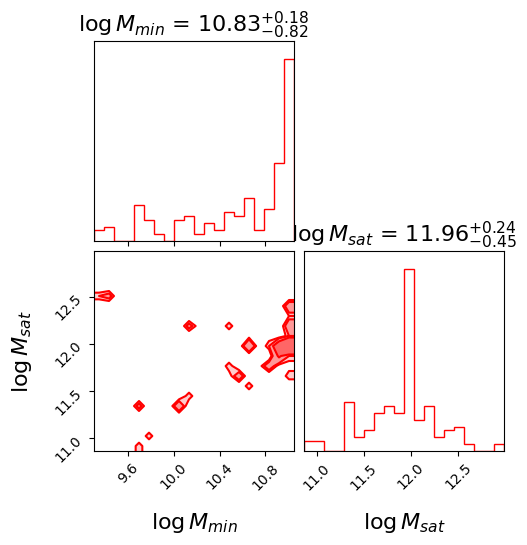

BEST FITS:
         M_min : 10.83 (+0.82 - 0.18)
         M_sat : 11.96 (+0.45 - 0.24)


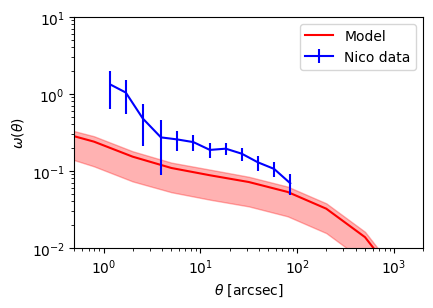

In [8]:
### PLOT CHAINS ###
__CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.5], #quantiles=[0.16, 0.5, 0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    # show_titles=True,
    max_n_ticks=6,
)

def get_samples(filepath):
    reader = emcee.backends.HDFBackend(filepath)
    if 0:
        tau = reader.get_autocorr_time(tol=0)
        burnin = int(2 * np.max(tau))
        thin = int(0.5 * np.min(tau))
        samples = reader.get_chain(discard=burnin, thin=thin)
    else:
        samples = reader.get_chain()
    return np.concatenate(samples, axis=0)


labels = [r'$\log M_{min}$', r'$\log M_{sat}$']
CORNER_KWARGS = dict(
    smooth=0.1,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    #quantiles=[0.16, 0.5, 0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    #max_n_ticks=3,
)

Z_OBSERVATION = 5.5
MCMC_z5 = get_samples('MCMC_chains/chains_2halo_z'+str(Z_OBSERVATION)+'.h5')
fig = corner.corner(MCMC_z5, color='r', labels=labels, **CORNER_KWARGS)
plt.show()


def get_percentiles(sample):
    Mmin_50 = np.percentile(sample[:, 0], 50)
    Mmin_16 = np.percentile(sample[:, 0], 16)
    Mmin_84 = np.percentile(sample[:, 0], 84)
    Msat_50 = np.percentile(sample[:, 1], 50)
    Msat_16 = np.percentile(sample[:, 1], 16)
    Msat_84 = np.percentile(sample[:, 1], 84)
    return [Mmin_50, Msat_50], [Mmin_16, Msat_16], [Mmin_84, Msat_84]

M50, M16, M84 = get_percentiles(MCMC_z5)
print(f'BEST FITS:')
print(f'         M_min : {M50[0]:.2f} (+{np.abs(M16[0]-M50[0]):.2f} - {np.abs(M84[0]-M50[0]):.2f})')
print(f'         M_sat : {M50[1]:.2f} (+{np.abs(M16[1]-M50[1]):.2f} - {np.abs(M84[1]-M50[1]):.2f})')

def get_Nico_obs(z):
    fnames = ['ACF_new_parameters_z5.5.txt',
            'ACF_new_parameters_z6.5.txt',
            'ACF_new_parameters_z7.4.txt',
            'ACF_new_parameters_z8.5.txt',
            'ACF_new_parameters_z9.3.txt',
            'ACF_new_parameters_z10.6.txt',
            'ACF_new_parameters_z11.5.txt']

    fname = fnames[int(int(z//1) - 5)]
    data = pd.read_csv('Data_Nico/'+fname, sep=' ')
    bin_centre = data['theta_bin'].to_numpy()
    w_obs = data['w_theta'].to_numpy()
    w_err = data['err_w_theta'].to_numpy()
    z_array = data['z_array'].to_numpy()
    Nz = data['Nz'].to_numpy()
    z_array, Nz = z_array[z_array>0], Nz[z_array>0]
    N_norm = Nz / (np.sum(Nz) * np.diff(z_array)[0])
    return bin_centre, w_obs, w_err, z_array, N_norm

bin_centre, w_obs, w_err, z_array, N_norm = get_Nico_obs(Z_OBSERVATION)
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)

th_arr = np.logspace(-0.5, 3.5, 11)/206265
sigma_logM, alpha = 0.2, 1.0
o2_B = HOD.omega_2halo_singleCore(th_arr, np.power(10, M50[0]), sigma_logM, np.power(10, M50[1]), alpha, N_norm, z_array,
                                  LOW_RES=1, mag_min = -22.3, mag_max = -15.5)
o2_U = HOD.omega_2halo_singleCore(th_arr, np.power(10, M84[0]), sigma_logM, np.power(10, M84[1]), alpha, N_norm, z_array,
                                  LOW_RES=1, mag_min = -22.3, mag_max = -15.5)
o2_L = HOD.omega_2halo_singleCore(th_arr, np.power(10, M16[0]), sigma_logM, np.power(10, M16[1]), alpha, N_norm, z_array,
                                  LOW_RES=1, mag_min = -22.3, mag_max = -15.5)

ax.plot(th_arr*206265, o2_B, c = 'r', ls = '-', label='Model')
ax.fill_between(th_arr*206265, o2_U, o2_L, color = 'r', alpha=0.3)
ax.errorbar(bin_centre,w_obs, w_err, c='b', label='Nico data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()